In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/bert_model.ckpt.index
/kaggle/input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/bert_model.ckpt.meta
/kaggle/input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/bert_config.json
/kaggle/input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/vocab.txt
/kaggle/input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/bert_model.ckpt.data-00000-of-00001
/kaggle/input/bert-pretrained-models/uncased_l-24_h-1024_a-16/uncased_L-24_H-1024_A-16/bert_model.ckpt.index
/kaggle/input/bert-pretrained-models/uncased_l-24_h-1024_a-16/uncased_L-24_H-1024_A-16/bert_model.ckpt.meta
/kaggle/input/bert-pretrained-models/uncased_l-24_h-1024_a-16/uncased_L-24_H-1024_A-16/bert_config.json
/kaggle/input/bert-pretrained-models/u

In [52]:
#!pip install pytorch_pretrained_bert


ERROR: Could not find a version that satisfies the requirement pylightgbm
ERROR: No matching distribution found for pylightgbm


In [89]:
# Utilities
import pandas as pd
import numpy as np
from os import path
import re

#Preprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Feature Enigineer
from tqdm import tqdm
import warnings
import torch
from transformers import BertModel, BertTokenizer
import torch

# Model
from sklearn import datasets, metrics, model_selection


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression

# EDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
warnings.filterwarnings(action='once')
device = torch.device('cuda')

<h1> Data Preprocessing 
    

In [11]:
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")

In [12]:
fake["label"] = 1
true["label"] = 0
fake_true = fake.append(true).reset_index()
del fake, true

In [13]:
# Check null value
fake_true.isnull().sum()

index      0
title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [14]:
# Check duplicate and remove duplicate rows
print("Duplicate rate is:", fake_true[fake_true.duplicated(keep="first")].shape[0] / fake_true.shape[0])

fake_true = fake_true[~fake_true.duplicated(keep="first")]

print("Duplicate rows removed...")

Duplicate rate is: 0.0
Duplicate rows removed...


In [16]:
# Preprocessing

punc =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
def remove_punc(x):
     return re.sub(punc , '' ,x)

tokenizer = RegexpTokenizer(r'\w+')
def tokenize(x):
    return tokenizer.tokenize(x.lower())

def remove_stopwords(x):
    word_list = [w for w in x if w not in stopwords.words("english")]
    return word_list

lemmatizer = WordNetLemmatizer()
def word_lemmatizer(x):
    lem = [lemmatizer.lemmatize(i) for i in x]
    return lem

stemmer = PorterStemmer()
def word_stemmer(x):
    stem = " ".join([stemmer.stem(i) for i in x])
    return stem

# Preprocessing on titles and texts
# fake_true["title_pre"] = fake_true["title"].apply(remove_punc).apply(tokenize).apply(remove_stopwords).apply(word_lemmatizer).apply(word_stemmer)
# fake_true["text_pre"] = fake_true["text"].apply(remove_punc).apply(tokenize).apply(remove_stopwords).apply(word_lemmatizer).apply(word_stemmer)

<H1> EDA

In [17]:
def word_cloud(dataset, title_text = "text", subject = None):
    if subject == None:
        dataset_filtered = dataset
    else:
        dataset_filtered = dataset[dataset["subject"] == subject]
    if title_text == "text":
        content = " ".join(list(dataset_filtered["text"]))
    else:
        content = " ".join(list(dataset_filtered["title"]))

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords = STOPWORDS, max_font_size=40).generate(content)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

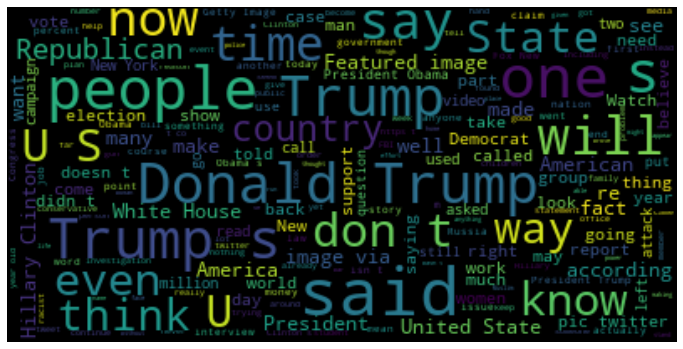

In [18]:
# Plot the word cloud of fake news text
word_cloud(fake_true[fake_true.label == 1], title_text = "text")

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


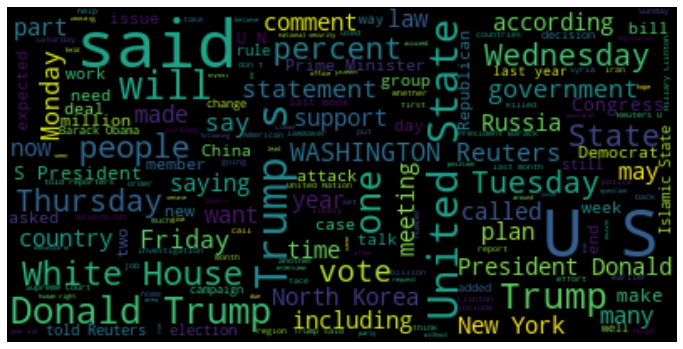

In [20]:
# Plot the word cloud of true news text
word_cloud(fake_true[fake_true.label == 0], "text")

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


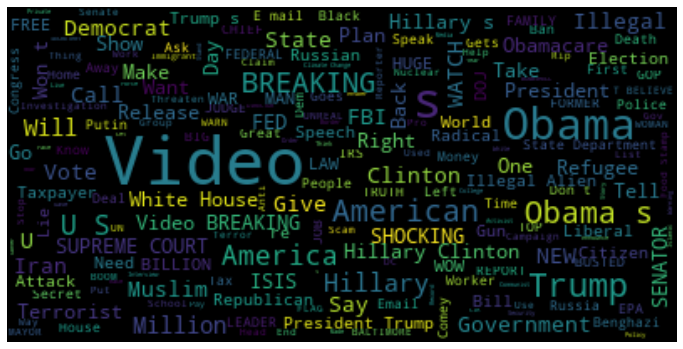

In [19]:
# Plot the word cloud of government fake news title 
word_cloud(fake_true[fake_true.label == 1], "title", "Government News")

In [21]:
class MyDataset:
    def __init__(self, df):
        # extract the text contents and labels
        self.title = df['title'].values
        self.text = df['text'].values
        self.title_pre = df['title_pre'].values
        self.text_pre = df['text_pre'].values
        self.labels = df["label"].values
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title_ = self.title[idx]
        text_ = self.text[idx]
        title_pre_ = self.title_pre[idx]
        text_pre_ = self.text_pre[idx]
        label_ = self.labels[idx]
        return title_, text_, title_pre_, text_pre_, label_

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<H1> Feature Engineering

Next I will extract title features from BERT encoder and text features using TF-IDF.

<h2> BERT

We extract the last hidden layer of BERT to serve as embedding features.

In [26]:
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

bert_hidden_states = []
for input_text in tqdm(list(fake_true["title"].values)):
    input_ids = tokenizer.encode(input_text, add_special_tokens=True)
    input_ids = torch.tensor([input_ids])

    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
    bert_hidden_states.append(last_hidden_states)

100%|██████████| 44898/44898 [1:05:42<00:00, 11.39it/s]


In [44]:
bert_hidden_states[0].shape

torch.Size([1, 24, 768])

In [58]:
bert_hidden_states_mean = []

for i in bert_hidden_states:
    bert_hidden_states_mean.append(torch.mean(i, dim=1))


for j in bert_hidden_states_mean:
    BERT_X.append(j[0].tolist())

<h2> TF-IDF

Use LDA to reduce dimensions of sparse matrix.

In [75]:
tfidf = TfidfVectorizer()
tf_idf_text = tfidf.fit_transform(fake_true["title"])
svd = TruncatedSVD(n_components=800)
tf_idf_text_svd = svd.fit_transform(tf_idf_text)


#X_train, X_test, y_train, y_test = train_test_split(tf_idf_text, fake_true['label'], test_size=0.2)

In [76]:
features = np.hstack((tf_idf_text_svd,np.array(BERT_X)))
X_train, X_test, y_train, y_test = train_test_split(features, fake_true['label'], test_size=0.2)

<H1> Classification Algorithm (Model)

<h2> Light GBM

In [91]:
gbm = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=20)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[1]	valid_0's l1: 0.475202	valid_0's binary_logloss: 0.645597
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.4528	valid_0's binary_logloss: 0.603792
[3]	valid_0's l1: 0.431449	valid_0's binary_logloss: 0.565582
[4]	valid_0's l1: 0.411204	valid_0's binary_logloss: 0.530697
[5]	valid_0's l1: 0.392019	valid_0's binary_logloss: 0.498757
[6]	valid_0's l1: 0.373747	valid_0's binary_logloss: 0.469311
[7]	valid_0's l1: 0.356333	valid_0's binary_logloss: 0.442016
[8]	valid_0's l1: 0.339807	valid_0's binary_logloss: 0.416825
[9]	valid_0's l1: 0.324095	valid_0's binary_logloss: 0.393445
[10]	valid_0's l1: 0.309181	valid_0's binary_logloss: 0.371791
[11]	valid_0's l1: 0.295012	valid_0's binary_logloss: 0.351658
[12]	valid_0's l1: 0.281476	valid_0's binary_logloss: 0.332783
[13]	valid_0's l1: 0.268615	valid_0's binary_logloss: 0.31516
[14]	valid_0's l1: 0.256372	valid_0's binary_logloss: 0.298693
[15]	valid_0's l1: 0.244695	valid_0's binary_logloss: 0.283246
[16]	va

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4246
           1       1.00      0.99      0.99      4734

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2> Logistic Regression

In [93]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [94]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4246
           1       1.00      1.00      1.00      4734

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The performance of LightGBM and Logistic Regression is already good enough. So I didn't explore more models such as LSTM and other deep learning models.

For this 2 models, the LightGBM will be preferred when there are more embedding features added. In this case, this leaf-based model can prevent overfitting in a good way.